In [2]:
!pip install sacrebleu
!pip install sacremoses
import pandas as pd
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import numpy as np
from tqdm.auto import tqdm, trange
import random
from torch import nn

In [3]:
src_file = '/kaggle/input/americasnlp-2024/data/chatino-spanish/train.es'
target_file = '/kaggle/input/americasnlp-2024/data/chatino-spanish/train.ctp'
tsv_data = '/kaggle/input/americasnlp-2024/data/chatino-spanish/extra.tsv'
parallel_data_src = None
parallel_data_target = None
target_lang = 'ctt_Latn' #chatino 
src_lang = 'spa_Latn' 

val_src = '/kaggle/input/americasnlp-2024/data/chatino-spanish/dev.es'
val_tar = '/kaggle/input/americasnlp-2024/data/chatino-spanish/dev.ctp'

In [4]:
def convert_to_list(file,parallel_data=None):
    lst = []
    if parallel_data==None:
        with open(file, 'r') as f:
            for line in f:
                lst.append(line.strip())
    else:
        with open(file, 'r') as f:
            for line in f:
                lst.append(line.strip())
        with open(parallel_data, 'r') as f:
            for line in f:
                lst.append(line.strip())
                print(line.strip())
    return lst

src_list = convert_to_list(src_file)
target_list = convert_to_list(target_file)

val_src = convert_to_list(val_src)
val_tar = convert_to_list(val_tar)

In [5]:
df = pd.DataFrame({src_lang: src_list, target_lang: target_list})
val_df = pd.DataFrame({src_lang: val_src, target_lang: val_tar})
print(len(df))
print(len(val_df))
df.head()

357
499


,spa_Latn,ctt_Latn
0,Amparo directo 9/2022.,shtyaᴴ shkaᴵ kyqyaᴬ chaqᶠ ktyinᴮ renqᴷ chaqᶠ n...
1,SCJN INVALIDA PORCIÓN NORMATIVA DE LA CONSTITU...,SJNQJKS NTYINᴮ SKAᴬ SKAᴵ Noᴬ NGAᴶ Leᴷ Noᴬ JYAN...
2,Concluyó al exponer que _x0093_las institucion...,ndyiᴬ ykwiqᴬ qanᴷ noᴷ waᶜ ntsaqᶠ chaqᶠ _ x0093...
3,La Sala concluyó que la medida de exclusión re...,Sqenᴬ neᴶ jyaqᶠ renqᴵ kyqyaᴬ ynoᴱ renqᴶ chaqᶠ ...
4,"Durante los días 10 y 11 de noviembre, represe...","""Neqᴬ tsanᴬ waᶜ 10 qoᴱ waᶜ 11 qoᴱ koᶠ suqᴮ, n..."


In [6]:
tsv_df = pd.read_csv(tsv_data, sep='\t',names=['_',src_lang,target_lang],on_bad_lines='skip')
tsv_df.drop(tsv_df.columns[0], axis=1, inplace=True) 
tsv_df = tsv_df[[tsv_df.columns[0], tsv_df.columns[1]]]
tsv_df

,spa_Latn,ctt_Latn
0,CONSTITUCIÓN POLÍTICA DE LOS ESTADOS UNIDOS ME...,LEE NDI'IN LO'O NE' SE'EN LYI'YA LOO CHIJYA'
1,Constitución publicada en el Diario Oficial de...,"Lee nu ngua'an scua re, mdo'o na loo QUITYI 'I..."
2,Última reforma publicada DOF 27-01-2015,Xiya' ti mdyi'o cui cha' re lo' nguinu scua na...
3,El C. Primer Jefe del Ejército Constitucionali...,NAN' nu lca que 'in x'nan sindatu 'in ne' Chij...
4,"VENUSTIANO CARRANZA, Primer Jefe del Ejército ...",NAN' YU VENUSTIANO CARRANZA. Nu lca que 'in x'...
...,...,...
2241,Al C. Lic.,Yu nu mchcuan cunta 'in na ca lca yu Licenciado.
2242,"Manuel Aguirre Berlanga, Subsecretario Encarga...","Manuel Aguirre Berlanga, yu nu lyi'ya cunta tñ..."
2243,Lo que hónrome en comunicar a usted para su pu...,"Lo'o suun ña'an tyaan cunta 'in na 'in um, si'..."
2244,"Constitución y Reformas.- México, cinco de feb...","Lee nu mdyi'o cui.- Chijya', cua' ca'yu lo'o c..."


In [33]:
syn_data = '/kaggle/input/americasnlp-2024/data/guarani-spanish/synthetic.tsv'
syn_df = pd.read_csv(syn_data, sep='\t',names=['_',src_lang,target_lang],on_bad_lines='skip')
syn_df.drop(syn_df.columns[0], axis=1, inplace=True) 
syn_df = syn_df[[syn_df.columns[0], syn_df.columns[1]]]
print(len(syn_df))
syn_df.head()

40417


,spa_Latn,grn_Latn
0,"930: Hucbaldo, monje y ⁇ de la zona de ⁇ (ar...","930: Hucbaldo, monje ha atõi ojapóva Hyãsia pe..."
1,Cuando se iba acercando el tiempo de su purifi...,"Upéi, are rire, okakuaapávo, Rubén imandu'a um..."
2,"1920: Paul Frees, la viuda de ⁇ (la muerte en...","1920: Paul Frees, mba'eapohára de voz Tetãvore..."
3,"1951: Chris Frantz, baterista de la Patria, de...","1951: Chris Frantz, baterista Tetã peteĩ reko ..."
4,"1952: Adolf Busch, violinista de la diáspora.","1952: Adolf Busch, violinista Alemáña pegua."


In [7]:
test = '/kaggle/input/americasnlp-2024/data/raramuri-spanish/test.es'
test_lst = convert_to_list(test)
test_df = pd.DataFrame({src_lang: test_lst})
len(test_df)

1003

In [35]:
df = pd.concat([df, tsv_df,syn_df])
print(len(df))
df.head()


108635


,spa_Latn,grn_Latn
0,La inauguración del edificio fue en coincidenc...,Inauguración edificio ojegueromandu'ávo cientí...
1,Cartes impulsa la candidatura de la exministra...,Cartes omokyre'ÿ candidatura exministra Corte ...
2,Los pobladores del barrio Pelopincho de Asunci...,Umi oikóva barrio Pelopincho Paraguaýpe he'i j...
3,El día de Corea,Korea retâ ára
4,"-Cante cien veces ""soy un perro"", con ritmo de...",-Epurahéi ñandéve sa jey “che peteî jagua” ha ...


In [36]:

print(len(df))

108635


In [37]:
#train val split
# train_size = 0.9
# df_shuffled = df.sample(frac=1, random_state=42)
# train_rows = int(train_size * len(df_shuffled))

# df = df_shuffled[:train_rows]
# val_df = df_shuffled[train_rows:]

In [38]:
df

,spa_Latn,grn_Latn
0,La inauguración del edificio fue en coincidenc...,Inauguración edificio ojegueromandu'ávo cientí...
1,Cartes impulsa la candidatura de la exministra...,Cartes omokyre'ÿ candidatura exministra Corte ...
2,Los pobladores del barrio Pelopincho de Asunci...,Umi oikóva barrio Pelopincho Paraguaýpe he'i j...
3,El día de Corea,Korea retâ ára
4,"-Cante cien veces ""soy un perro"", con ritmo de...",-Epurahéi ñandéve sa jey “che peteî jagua” ha ...
...,...,...
40412,"Finalmente decimos ""segunda: una larga espera""...","Ipahápe ja'ekuaa ""kõingue: ava ha avano'õ"" oip..."
40413,Por ejemplo: ciencia (filosofía) y matemáticas.,Techapyrã: arandupykuaaty (filosofía) ha papap...
40414,El Refugio Biológico de TAT ⁇ JUPI está en la...,Ko Refugio Biológico de TATĨ JUPI hérava oĩ tá...
40415,"2000: Escudos amarillos, y ⁇ rojo;","2000: Willow Shields, mba'eapohára Tetãvore Jo..."


/tmp/ipykernel_33/4052471578.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_length_col1'] = df[col1].apply(lambda x: len(x.split()))
/tmp/ipykernel_33/4052471578.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_length_col2'] = df[col2].apply(lambda x: len(x.split()))
/tmp/ipykernel_33/4052471578.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

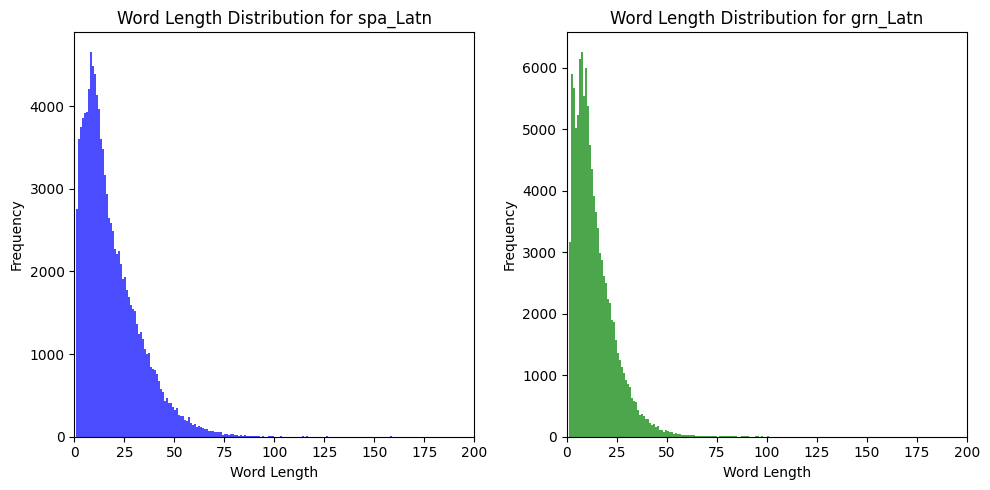

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

col1 = src_lang
col2 = target_lang

df = df.dropna(subset=[col1, col2])

df['word_length_col1'] = df[col1].apply(lambda x: len(x.split()))
df['word_length_col2'] = df[col2].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df['word_length_col1'], color='blue', alpha=0.7, bins=range(200))
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Distribution for ' + col1)
plt.xlim(0, 200)


plt.subplot(1, 2, 2)
plt.hist(df['word_length_col2'], color='green', alpha=0.7, bins=range(200))
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Distribution for ' + col2)
plt.xlim(0, 200) 

df.drop(['word_length_col1', 'word_length_col2'], axis=1, inplace=True)


plt.tight_layout()


plt.show()


In [8]:
import pandas as pd
import re

def max_avg_sentence_length(dataframe, column_name):

    def sentence_length(sentence):
        return len(re.findall(r'\w+', sentence))


    dataframe['sentence_length'] = dataframe['spa_Latn'].apply(sentence_length)

    max_length = dataframe['sentence_length'].max()
    avg_length = dataframe['sentence_length'].mean()

    dataframe.drop(columns=['sentence_length'], inplace=True)

    return max_length, avg_length


max_length, avg_length = max_avg_sentence_length(test_df, 'spa_Latn')
print("Maximum sentence length:", max_length)
print("Average sentence length:", avg_length)

Maximum sentence length: 42
Average sentence length: 10.019940179461615


In [41]:
from transformers import NllbTokenizer

model_name = "facebook/nllb-200-distilled-600M"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer = NllbTokenizer.from_pretrained(model_name)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [42]:

if target_lang not in  tokenizer.additional_special_tokens:
    new_special_tokens = tokenizer.additional_special_tokens + [target_lang]
    tokenizer.add_special_tokens({'additional_special_tokens': new_special_tokens})
    print('added_special token')
    
if src_lang not in  tokenizer.additional_special_tokens:
    new_special_tokens = tokenizer.additional_special_tokens + [src_lang]
    tokenizer.add_special_tokens({'additional_special_tokens': new_special_tokens})
    print('added_special token')

In [43]:
#cheaks for number of unk in tokens

texts_with_unk = [
    text for text in tqdm(df[target_lang])
    if tokenizer.unk_token_id in tokenizer(text).input_ids
]
print(len(texts_with_unk))

  0%|          | 0/108596 [00:00<?, ?it/s]

22760


In [12]:
import re
import sys
import unicodedata
from sacremoses import MosesPunctNormalizer

mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]

def get_non_printing_char_replacer(replace_by: str = " "):
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [45]:
texts_with_unk_normed = [
    text for text in tqdm(texts_with_unk) 
    if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids
]
print(len(texts_with_unk_normed))  

  0%|          | 0/22760 [00:00<?, ?it/s]

98


In [46]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.cuda();
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

In [20]:
# import random
# LANGS = [(src_lang,src_lang), (target_lang, target_lang)]


# def get_batch_pairs(batch_size, data=df):
#     (l1, long1), (l2, long2) = (src_lang, src_lang),(target_lang, target_lang)
#     xx, yy = [], []
#     for _ in range(batch_size):
#         item = data.iloc[random.randint(0, len(data)-1)]
#         xx.append(item[l1])
#         yy.append(item[l2])
#     return xx, yy, long1, long2

# print(get_batch_pairs(1))


In [47]:
import random
LANGS = [(src_lang,src_lang), (target_lang, target_lang)]
def get_batch_pairs(batch_size, data=df):
    (l1, long1), (l2, long2) = (src_lang, src_lang),(target_lang, target_lang)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))


(['El evento tuvo lugar el 31 de marzo de 2018.'], ['Ojehechákuri árape: 31 de marzo de 2018.'], 'spa_Latn', 'grn_Latn')


In [48]:
import gc
import torch
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

In [8]:
def translate(
    text, src_lang=src_lang, tgt_lang=target_lang,
    a=32, b=3, max_input_length=50, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = 'tar_Latn'
    inputs = tokenizer(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model.eval() # turn off training mode
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)[0]


In [49]:
import os
batch_size = 16 #32 already doesn't fit well to 15GB of GPU memory
max_length = 64# token sequences will be truncated
training_steps = 20000 
# and then just interrupt the training manually
losses = []  # with this list, I do very simple tracking of average loss
MODEL_SAVE_PATH = '/kaggle/working/guarani/models'
if 'guarani' not in os.listdir('/kaggle/working/'):
    os.mkdir('/kaggle/working/guarani/')

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++


model.train()
x, y, loss = None, None, None
cleanup()
tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        # -100 is a magic value ignored in the loss function
        # because we don't want the model to learn to predict padding ids
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:  # usually, it is out-of-memory
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        # each 1000 steps, I report average loss at these steps
        print(i, np.mean(losses[-1000:]))
        
    if i % 5000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH+str(i))
        tokenizer.save_pretrained(MODEL_SAVE_PATH+str(i))
        print("model saved ")

    if i% 5000 == 0 and i>0:
        tqdm.pandas(desc="Applying function")
        val_df[target_lang + '_translated'] = val_df[src_lang].progress_apply(translate)
        val_df.to_csv(f'/kaggle/working/guarani/op{i}.csv', index=False) 
        val_df.to_excel(f'/kaggle/working/guarani/op{i}.xlsx', index=False)
        b =bleu_calc.corpus_score(val_df[val_df.columns[2]].tolist(), [val_df[val_df.columns[1]].tolist()])
        c = chrf_calc.corpus_score(val_df[val_df.columns[2]].tolist(), [val_df[val_df.columns[1]].tolist()])
        print("bleu score : ",b.score)
        print("chrf score : ",c.score)
        model.train()
        

In [ ]:
# tqdm.pandas(desc="Applying function")
# val_df[target_lang + '_translated'] = val_df[src_lang].progress_apply(translate)
# val_df.to_csv('/kaggle/working/outputmodel_shipibo_konibo.csv', index=False) 
# val_df.to_excel('/kaggle/working/outputmodel_shipibo_konibo.xlsx', index=False)

In [ ]:
# val_df = pd.read_csv('/kaggle/working/output.csv')
# val_df.head()

# import sacrebleu

# bleu_calc = sacrebleu.BLEU()
# chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++
# b =bleu_calc.corpus_score(val_df[val_df.columns[2]].tolist(), [val_df[val_df.columns[1]].tolist()])
# c = chrf_calc.corpus_score(val_df[val_df.columns[2]].tolist(), [val_df[val_df.columns[1]].tolist()])
# print(b)
# print(c)

In [11]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM
model_load_name = '/kaggle/working/raramuri/models'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)

the `lang_code_to_id` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
the `fairseq_tokens_to_ids` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
src_lang

'spa_Latn'

In [18]:
def translate(
    text, src_lang=src_lang, tgt_lang=target_lang,
    a=32, b=3, max_input_length=50, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = 'tar_Latn'
    inputs = tokenizer(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model.eval() # turn off training mode
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)[0]


In [19]:
import re
import sys
import unicodedata
from sacremoses import MosesPunctNormalizer

mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]

def get_non_printing_char_replacer(replace_by: str = " "):
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:

def process_file(input_file, output_file):
    with open(input_file, 'r') as infile:
        with open(output_file, 'w') as outfile:
            for line in infile:
                processed_line = translate(preproc(line))
                outfile.write(processed_line)

# Define input and output file paths
input_file_path = '/kaggle/input/americasnlp-2024/data/raramuri-spanish/test.es'
output_file_path = 'output.txt'

# Process the input file and save the output
process_file(input_file_path, output_file_path)